0
1
2
3
4
5
6
7
8
9


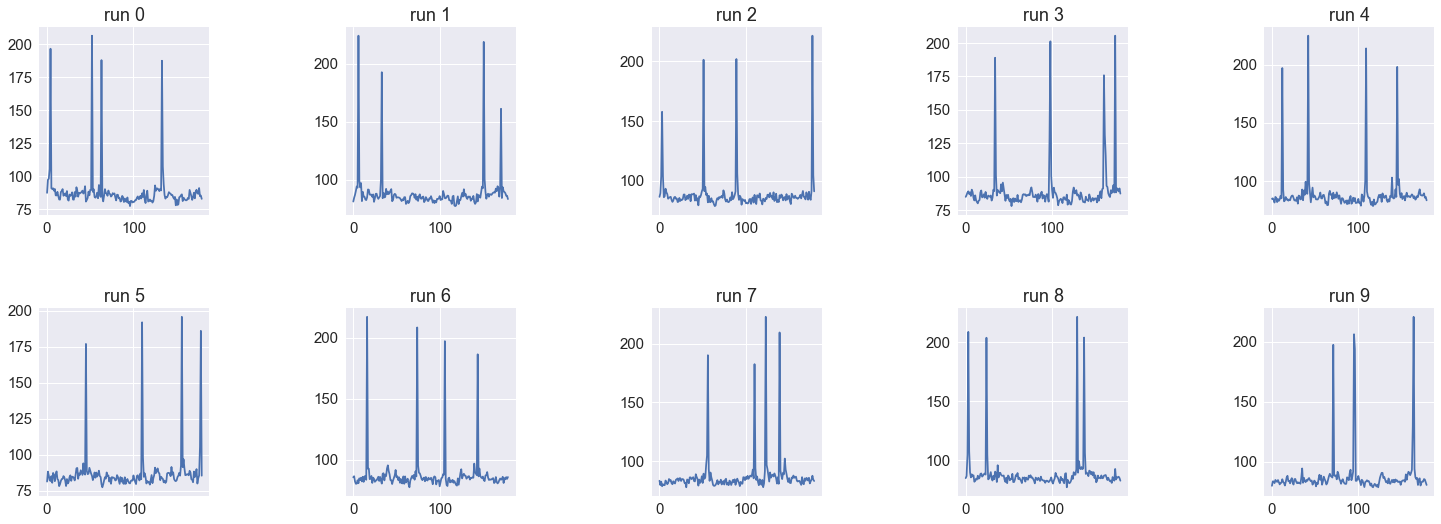

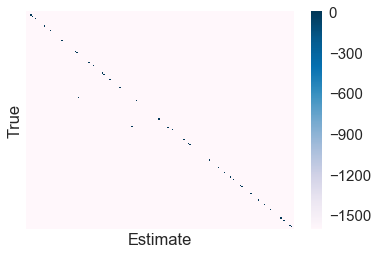

In [2]:
#Implementation found in https://github.com/dengjunquan/DoA-Estimation-MUSIC-ESPRIT/blob/master/DoAEstimation.py
# https://dengjunquan.github.io/posts/2018/08/DoAEstimation_Python/

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import scipy.signal as ss
import itertools
import operator
import math
import os
import datetime
import logging
import seaborn as sns




#### LITTLE BUG if one of the thetas is in the extremes (0 or 179) the graph is good but peak not retrieved
# because the function find_peaks of scipy signal don't consider it a peak

# Functions

# Taken from https://github.com/swing-research/scatsense/blob/master/core/signal.py 
# Code written by Dalia El Badawy
def calculate_angle_error(theta,theta_hat,angles):
    '''Average localization error in degrees (modulo 360)
    Also finds the best permutation that gives the lowest error
    Input:
        theta: array of true indices
        theta_hat: array of estimated indices
        angles: list of angles in degrees
    '''
    J = len(theta) #number of sources
    all_perms = itertools.permutations(theta_hat) #all permutations
    min_err = np.Inf

    for beta in all_perms:
        curr_err = np.sum(np.absolute(((angles[np.array(beta)]-angles[theta]+180) % 360)-180))*1./J;
        if curr_err<min_err:
            min_err = curr_err
            perm = np.array(beta)
            
    return min_err,perm

'''
return the n highest peaks of the function spectrum if it finds more than n peak 
after 10 iterations reducing the necessary height and prominence of the find_peaks method of signal
if, even after these iterations, it didn't found n peaks it returns the ones it found
(There was a problem if the number of sent peaks were not equal to the number of sources so 
if that's the case i add the necessary peaks by adding random ones)
'''
def findNpeaks(numberPeaks, spectrum, h):
    height = h
    prominence = height/10
    iteration = 0
    maxIteration = 10
    DoAsMUSIC,_= ss.find_peaks(spectrum ,height = height, prominence = prominence)
    while(DoAsMUSIC.size < numberPeaks and iteration < maxIteration):
        height = height/2
        prominence = height/10
        iteration = iteration + 1
        DoAsMUSIC,_= ss.find_peaks(spectrum ,height = height, prominence = prominence)
    if(DoAsMUSIC.size > numberPeaks):
        return n_highest(numberPeaks, DoAsMUSIC, spectrum)
    elif(DoAsMUSIC.size == numberPeaks):
        return DoAsMUSIC
    else:
        DoAsWithRandom = DoAsMUSIC
        for i in range(DoAsMUSIC.size, numberPeaks):
            DoAsWithRandom = np.append(DoAsWithRandom, random.randint(0,spectrum.shape[0]))
        return DoAsWithRandom
    
'''
return the "numberPeaks" highest values of a list (declared as a numpy array) of indexes (DoAsMUSIC)
with values in "spectrum"
'''
def n_highest(numberPeaks, DoAsMUSIC, spectrum):
    n_highest = []
    temp = DoAsMUSIC
    for i in range(numberPeaks):
        value = 0
        index = -1
        for j in range(temp.size):
            if(spectrum[temp[j]] > value):
                index = j
                value = spectrum[temp[j]]
        n_highest.append(temp[index])
        temp = np.delete(temp, index)
    return n_highest
    

'''
'''
def music(CovMat,L,N,array,Angles, frequency):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements 
    #(array and Angles ONLY USEFUL FOR response vector so should give response vector instead)
    # Angles are the grid of directions in the azimuth angular domain
    _,V = LA.eig(CovMat)
    Qn  = V[:,L:N]
    numAngles = Angles.size
    pspectrum = np.zeros(numAngles)
    for i in range(numAngles):
        av = array[:,Angles[i],frequency]
        pspectrum[i] = 1/LA.norm((Qn.conj().transpose()@av))
    
    psindB    = np.log10(10*pspectrum/pspectrum.min())
    return psindB


outpath = os.path.join('output',  '{:%Y%m%d_%H%M}'.format(datetime.datetime.now()))
if not os.path.exists(outpath):
    os.makedirs(outpath)

logfile = os.path.join(outpath, "log.txt")

logging.basicConfig(filename=logfile, format='%(asctime)s %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)


lamda = 1 # wavelength
kappa = np.pi/lamda # wave number
L = 4  # number of sources
snr = 20 # signal to noise ratio
n_samples = 128
discretization = 0


dev = 'lego' # Change if using Kemar or lego
logger.info('Load transfer functions %s'%dev)

if dev == 'lego':
    discretization = 2
    H_theta_time_total = np.load('lego1_h_theta_time.npy')    

#Change Kemar discretization to be every 2 degrees

if dev == 'kemar':
    discretization = 2
    H_theta_time_total = np.load('kemar_h_theta_1deg_time.npy')   
    H_theta_time_total = H_theta_time_total[:,::discretization,:]


runs = 10

logger.info('Number of runs %s'%(runs))
logger.info('Noise in decibel %s'%(snr))
logger.info('Number of sources %s'%(L))

number_mics = H_theta_time_total.shape[2]
N = number_mics


H_theta_freq_total = []
for mic in range(number_mics):
    H_theta_freq_total.append(np.fft.rfft(np.transpose(H_theta_time_total[:,:,mic]), n_samples))

H_theta_freq_total = np.asarray(H_theta_freq_total)

numFrequencies = H_theta_freq_total.shape[2]

logger.info('Number of frequencies %s'%(numFrequencies))    

#Example Getting the first frquency of the 12th angle
#H_theta_freq_test = H_theta_freq_total[:,12,1]
    
Df = H_theta_freq_total.shape[1] #number of directions for a fine discretization
xPlot = 10 #runs/yplot
yPlot = 5 #runs/xplot
fig = plt.figure(figsize=(25,50))#give enough size to plot 50 subplots

# list of indices for the different angles (if we want the degrees we do times discretization)
Angles = np.arange(Df, dtype=np.int64)*360./Df 
Angles = (Angles/discretization).astype(int)

numAngles = Angles.size


conf_matrix = np.zeros((numAngles, numAngles)) #confusion  matrix
#To keep the minimal error between each source at each run 
min_err_by_run = np.zeros(runs)

err_per_source = np.zeros((runs, L))


for rns in range(runs):
    print(rns)

    # random source directions(it's the indices, for degrees times discretization)
    Thetas = np.random.choice(range(Df), L, replace=False) 

    Alphas = np.random.randn(L) + np.random.randn(L)*1j # random source powers

    Alphas = np.sqrt(1/2)*Alphas

    psindTotal = np.zeros((Df, ))    
    
    #not taking the first frequency because neutral one
    for frequency in range (1, numFrequencies): 

        numrealization = 100
        H = np.zeros((N,numrealization)) + 1j*np.zeros((N,numrealization))
        for iter in range(numrealization):
            htmp = np.zeros(N)
            #Signal generation
            for i in range(L):
                pha = np.exp(1j*2*np.pi*np.random.rand(1))
                htmp = htmp + pha*Alphas[i]*H_theta_freq_total[:,Thetas[i],frequency]
            #Adding noise
            H[:,iter] = htmp + np.sqrt(0.5/snr)*(np.random.randn(N)+np.random.randn(N)*1j)
        CovMat = H@H.conj().transpose()

        # MUSIC algorithm
        psindB = music(CovMat,L,N,H_theta_freq_total,Angles, frequency)

        psindTotal = psindTotal + psindB

    DoAsMUSIC = findNpeaks(L, psindTotal, n_samples)

    plt.subplot(xPlot, yPlot, rns+1)
    plt.plot(Angles,psindTotal)
    plt.plot(Angles[DoAsMUSIC],psindTotal[DoAsMUSIC],'x')
    plt.title('run %s'%(rns))
    
    
    
    indexesToAngles = Angles*discretization
    
    #min_err is the average error for this run (named min_err because it's the minimum error for the permutations)
    min_err, best_perm = calculate_angle_error(Thetas, DoAsMUSIC, indexesToAngles) #calculate error between chosen and true directions
    conf_matrix[Thetas, best_perm] += 1

    min_err_by_run[rns] = min_err

    for src_j in range(L): #error per source
        err_per_source[rns, src_j] = np.sum(np.absolute(((best_perm[src_j]-Thetas[src_j]+180) % 360)-180))

    logger.info('Test %s, Actual DoAs: %s, MUSIC DoAs: %s, err: %s'%(rns, indexesToAngles[Thetas], indexesToAngles[best_perm], min_err))


logger.info('Err_per_source average: %s, median: %s, Min_err average: %s, median: %s'%(np.mean(err_per_source, axis=0), np.median(err_per_source, axis=0), np.mean(min_err_by_run, axis=0), np.median(min_err_by_run, axis=0)))
logger.info('Err_per_source max: %s, min: %s, Min_err max: %s, min: %s'%(np.max(err_per_source, axis=0), np.min(err_per_source, axis=0), np.max(min_err_by_run, axis=0), np.min(min_err_by_run, axis=0)))

plt.subplots_adjust(wspace=0.8, hspace=0.5)
plt.plot
plt.savefig(os.path.join(outpath, 'music.png'))

sns.set_style("whitegrid")
sns.set(font_scale=1.5) 
cmap = "PuBu"

plt.figure()
hm = sns.heatmap(20*np.log10(conf_matrix+1e-80), cmap=cmap, xticklabels=False,  yticklabels=False)
plt.xlabel('Estimate')
plt.ylabel('True')
plt.plot
plt.savefig(os.path.join(outpath, 'conf_matrix.png'))
